In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
def get_agg_pool_vol(df_filepaths: str, blockchain: list[str]) -> pl.DataFrame:
    '''
    Returns pool_id aggregated by most volume
    '''
    q = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('blockchain') == blockchain)
    .sort("timestamp", descending=False)
    .groupby("pool_id").agg(pl.col("amountInUSD").sum()) 
    .sort("amountInUSD", descending=True)
    )

    return q.collect()

def get_pool_tokens(df_filepaths: str, pool_list, blockchain: str) -> dict:
    '''
    Generate a pool name based on the token composition of the pool. Returns a dict of pool names
    '''
    # filter pools by pool_list

    pool_name_dict =  {}

    #convert values in pool_list to lowercase letters using a list comprehension
    pool_list_underscore = [x.lower() for x in pool_list]

    # scan for pool list values
    q = (
        pl.scan_parquet(df_filepaths, use_statistics=True)
        .filter(pl.col('pool_id').is_in(pool_list_underscore)).unique()
    ).unique()
    
    df = q.collect()
    
    for pool in pool_list_underscore:
        # filter df by pool
        pool_df = df.filter(pl.col('pool_id') == pool)
        # get tokenIn and tokenOut symbols
        tokenIn = pool_df['tokenIn_symbol'].unique().to_list()
        tokenOut = pool_df['tokenOut_symbol'].unique().to_list()
        # generate pool name from tokenIn and tokenOut. Exclude duplicate values
        pool_name = list(set(tokenIn + tokenOut))

        # sort list alphabetically
        pool_name = pool_name

        pool_name = '/'.join(pool_name)
        # pool_name = '/'.join(pool_name) + ' (' + blockchain + (')')

        pool_name_dict[pool] = pool_name

    names_df = pl.from_dict(pool_name_dict).transpose(include_header=True, header_name="pool_id", column_names=["pool_name"])

    return names_df

In [4]:
def generate_agg_pool_vols(df_filepaths: str, blockchain: str, n_pools=10) -> pl.DataFrame:
    '''
    Returns a dataframe of pool_id, pool_name, and aggregated volume
    '''
    agg_blockchain_pools = get_agg_pool_vol(df_filepaths, blockchain)

    # get list of pool_ids
    top_pools = agg_blockchain_pools['pool_id'].head(n_pools).to_list()

    # generate pool names
    pool_name_dict = get_pool_tokens(df_filepaths, top_pools, blockchain)

    # join eth_data and pool_name_dict
    pool_names_joined = agg_blockchain_pools.join(pool_name_dict, on='pool_id')

    # add blockchain column
    pool_names_joined = pool_names_joined.with_columns(pl.lit(blockchain).alias('blockchain'))

    return pool_names_joined

In [5]:
pool_size = 5

eth_df = generate_agg_pool_vols(df_filepaths, 'ethereum', n_pools=pool_size)
arb_df = generate_agg_pool_vols(df_filepaths, 'arbitrum', n_pools=pool_size)
bsc_df = generate_agg_pool_vols(df_filepaths, 'bsc', n_pools=pool_size)
opt_df = generate_agg_pool_vols(df_filepaths, 'optimism', n_pools=pool_size)
matic_df = generate_agg_pool_vols(df_filepaths, 'polygon', n_pools=pool_size)

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [6]:
# concat dataframes
pool_vol_df = pl.concat([eth_df, arb_df, bsc_df, opt_df, matic_df])

# sort
pool_vol_df = pool_vol_df.sort('amountInUSD', descending=True)

In [7]:
pool_vol_df_pandas = pool_vol_df.to_pandas()

In [8]:
pool_vol_df_pandas

,pool_id,amountInUSD,pool_name,blockchain
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,3.132459e+10,USDC/WETH,ethereum
1,0xc31e54c7a869b9fcbecc14363cf510d1c41fa443,1.141490e+10,USDC/WETH,arbitrum
2,0x3416cf6c708da44db2624d63ea0aaef7113527c6,9.148422e+09,USDC/USDT,ethereum
3,0x11b815efb8f581194ae79006d24e0d814b7697f6,7.796986e+09,WETH/USDT,ethereum
4,0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf,4.984067e+09,USDC/USDT,ethereum
5,0xc6f780497a95e246eb9449f5e4770916dcd6396a,4.617324e+09,ARB/WETH,arbitrum
6,0x641c00a822e8b671738d32a431a4fb6074e5c79d,3.754022e+09,WETH/USDT,arbitrum
7,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,3.423121e+09,WETH/WBTC,ethereum
8,0xcda53b1f66614552f834ceef361a8d12a0b8dad8,2.073708e+09,ARB/USDC,arbitrum
9,0x45dda9cb7c25131df268515131f647d726f50608,1.598114e+09,USDC/WETH,polygon


### Plotting

In [9]:
# groupby blockchain groupby pool_name and sum amountInUSD
pool_vol_df_pandas = pool_vol_df_pandas.groupby(['blockchain', 'pool_name']).sum(numeric_only=True).reset_index()

In [10]:
# create a hierarchical dataframe
pool_vol_df_pandas_hier = pool_vol_df_pandas.set_index(['blockchain', 'pool_name'])

# sort by amountInUSD
pool_vol_df_pandas_hier = pool_vol_df_pandas_hier.sort_values(by=['blockchain', 'amountInUSD'], ascending=False)

# drop lowest amountInUSD value row for polygon blockchain index. Manual inspection shows the index of the row to be dropped is 4
# pool_vol_df_pandas_hier = pool_vol_df_pandas_hier.drop(pool_vol_df_pandas_hier.index[4])

In [11]:
pool_vol_df_pandas_hier.groupby('blockchain').count()

,amountInUSD
blockchain,
arbitrum,4
bsc,4
ethereum,4
optimism,4
polygon,5


In [17]:
# save pool_vol_df_pandas_hier to csv
pool_vol_df_pandas_hier.to_csv('data/pool_vol_df_pandas_hier.csv')

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib._color_data as mcd

import numpy as np

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

In [13]:
# filter by blockchain
eth_pools = pool_vol_df_pandas_hier.loc['ethereum'].sort_values(by=['amountInUSD'], ascending=False)
arb_pools = pool_vol_df_pandas_hier.loc['arbitrum'].sort_values(by=['amountInUSD'], ascending=False)
bsc_pools = pool_vol_df_pandas_hier.loc['bsc'].sort_values(by=['amountInUSD'], ascending=False)
opt_pools = pool_vol_df_pandas_hier.loc['optimism'].sort_values(by=['amountInUSD'], ascending=False)
matic_pools = pool_vol_df_pandas_hier.loc['polygon'].sort_values(by=['amountInUSD'], ascending=False)

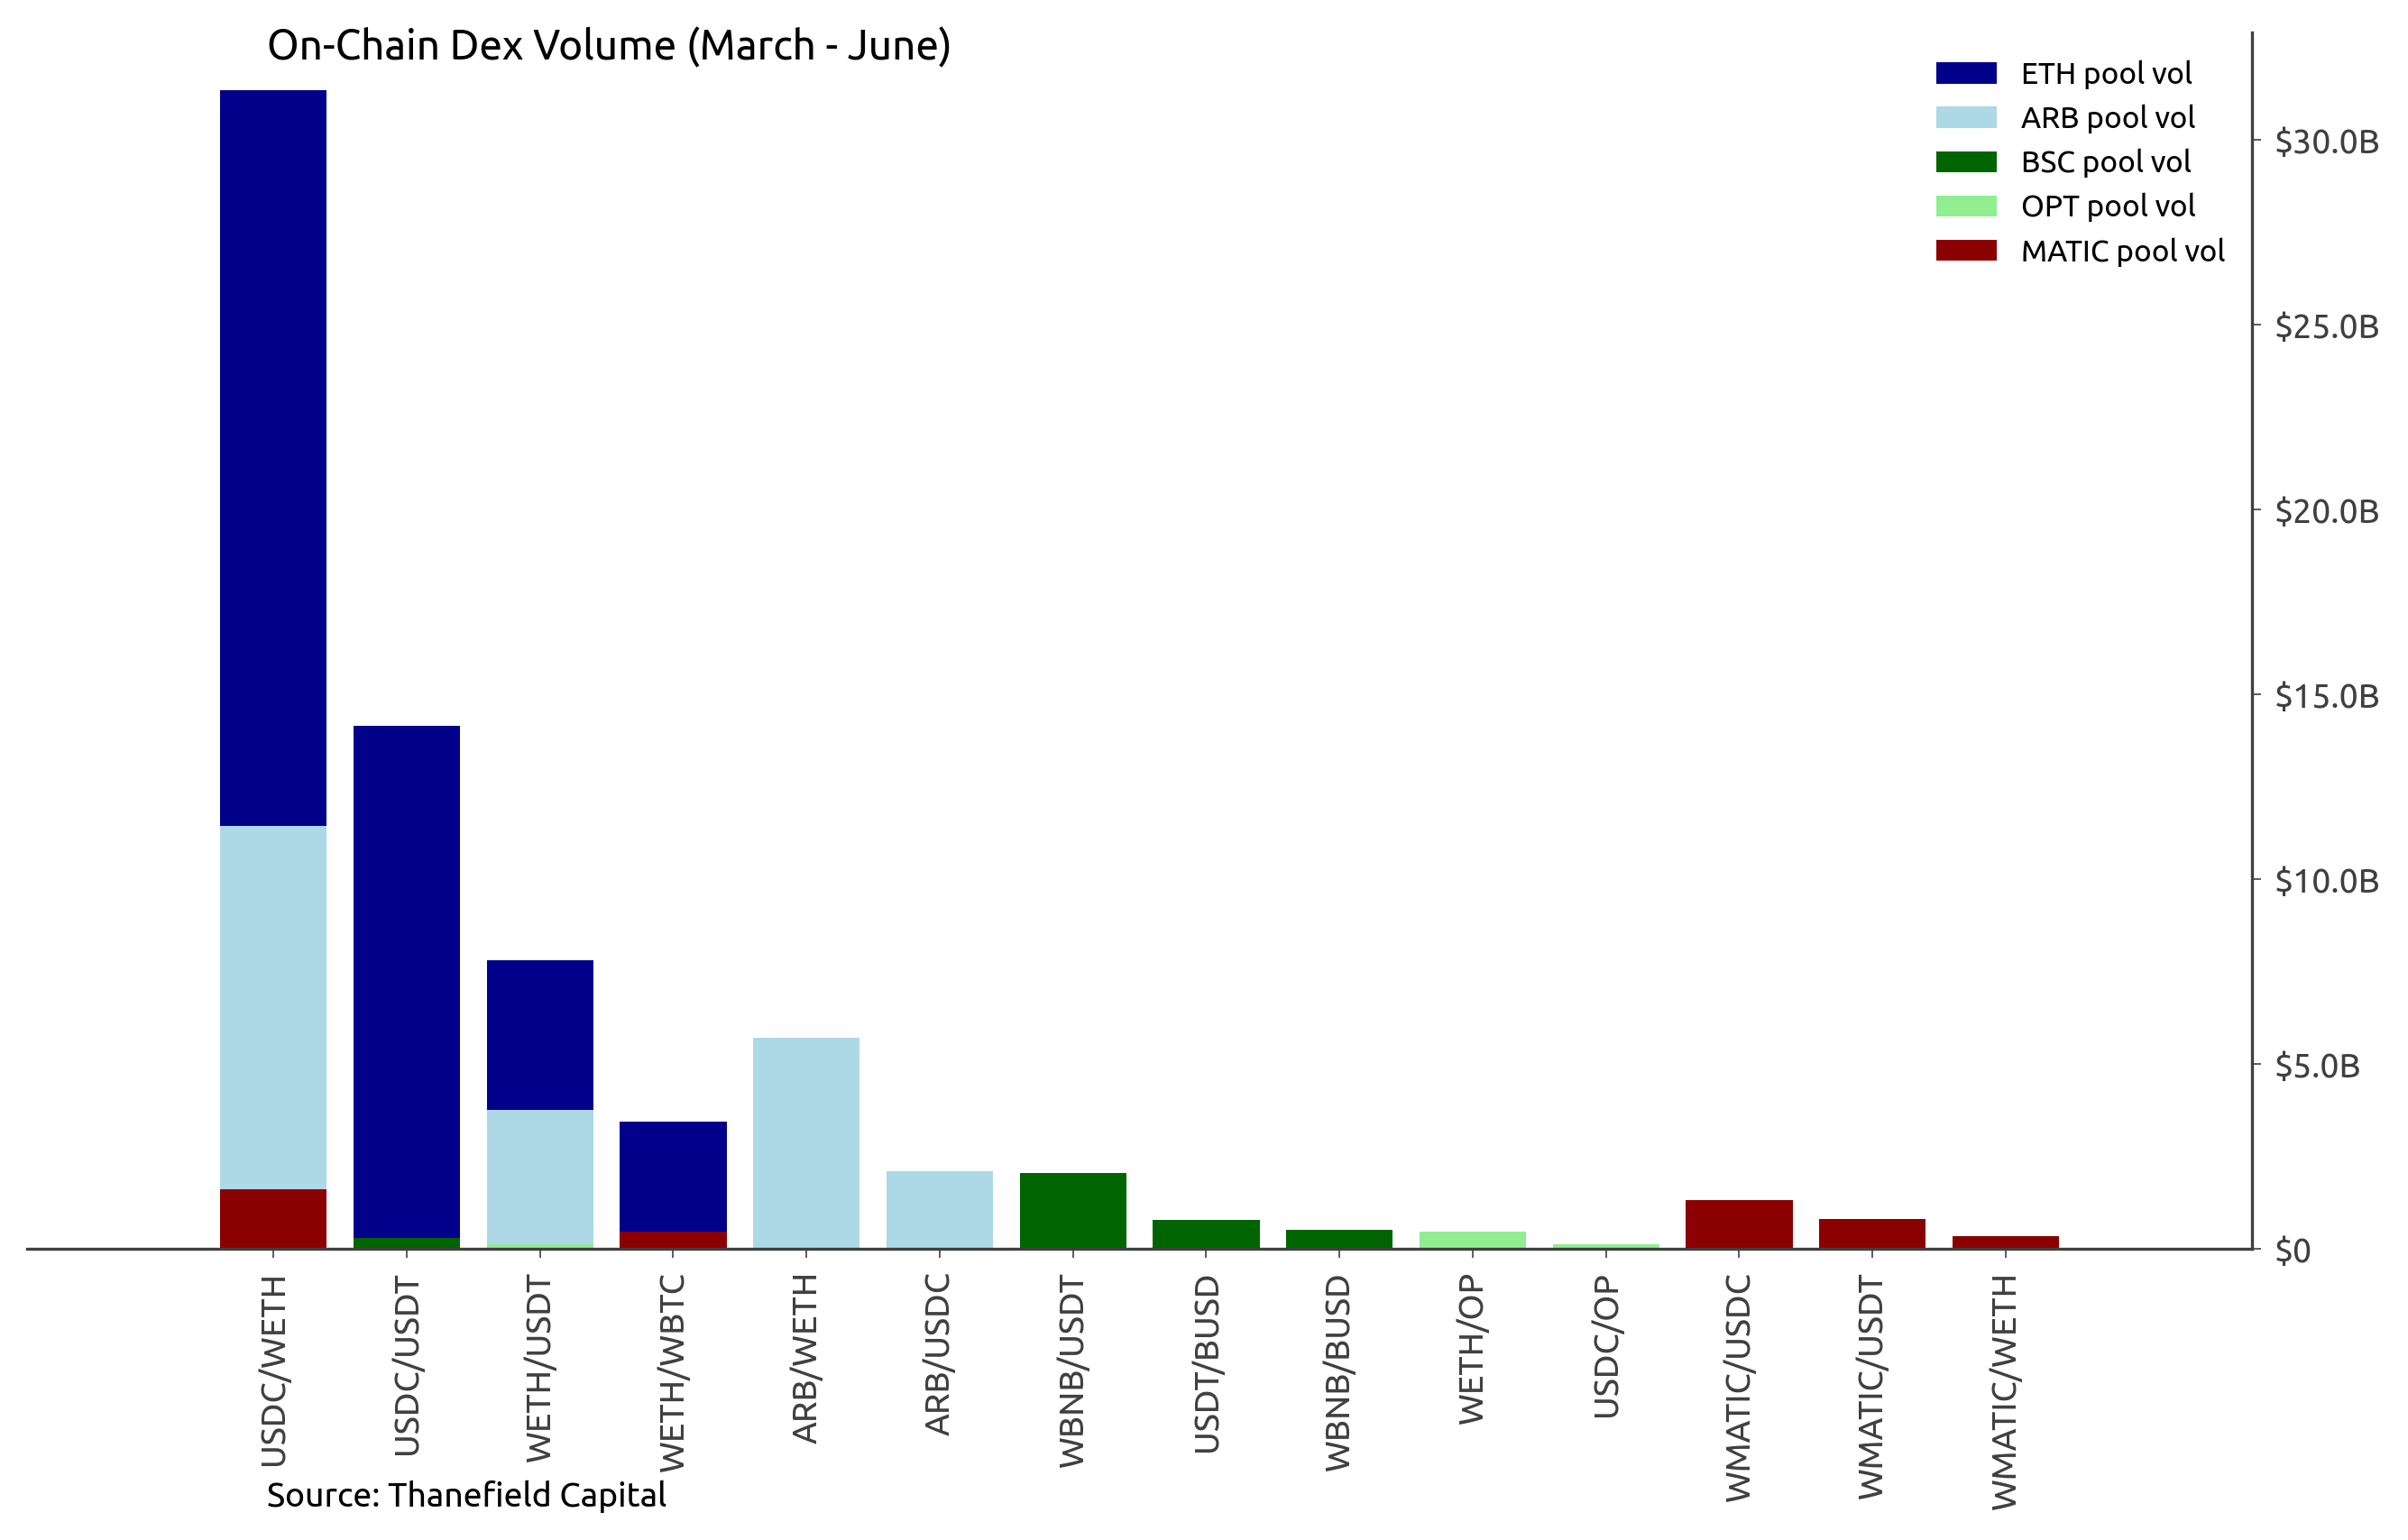

In [18]:
fig, ax = tc.chart('Total Pool Dex Volume (March - June)', dates=False)

ax.bar(eth_pools.index, eth_pools['amountInUSD'], color='darkblue', label='ETH pool vol')
ax.bar(arb_pools.index, arb_pools['amountInUSD'], color='lightblue', label='ARB pool vol')
ax.bar(bsc_pools.index, bsc_pools['amountInUSD'], color='darkgreen', label='BSC pool vol')
ax.bar(opt_pools.index, opt_pools['amountInUSD'], color='lightgreen', label='OPT pool vol')
ax.bar(matic_pools.index, matic_pools['amountInUSD'], color='darkred', label='MATIC pool vol')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)

# save chart
tc.save('charts/onchain_dex_pool_vol.png')